In [1]:
## Overview 

In [12]:
### Import Libraries
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import time
import sys
import glob
sys.path.insert(0,'../../../../../utils/')
from helper_functions_genus import *
#import helper_function custom library
from model_builder_genus import ModelBuilder
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [13]:
### Import and Clean Data
#load spectra data
#import_spectra
spectra = pd.read_csv("../../../../../data/imp_bands.csv")
df_aug = pd.read_csv("../../../../../data/refCanopies0802_0630.txt")
df_sep = pd.read_csv("../../../../../data/refCanopies0917_0630.txt")
df_oct = pd.read_csv("../../../../../data/refCanopies1016_0630.txt")

#load tree data
df_tree = pd.read_csv("../../../../../data/Export_Output_2_0630_Genus.txt")

In [14]:
#select 22 bands only
cols = list(df_aug.columns[:8]) + ['450.41','652.35','540.72','848.93']
df_aug = df_aug[cols]
df_sep = df_sep[cols]
df_oct = df_oct[cols]
df_aug.head()

,ROIID,IDwithROI,X,Y,MapX,MapY,Lat,Lon,450.41,652.35,540.72,848.93
0,1,1,6558,1881,697516.92,4522326.17,40.828198,-96.657615,0.0180,0.0240,0.0271,0.1384
1,1,2,6559,1881,697517.52,4522326.17,40.828198,-96.657608,0.0186,0.0238,0.0257,0.1424
2,1,3,6560,1881,697518.12,4522326.17,40.828198,-96.657600,0.0188,0.0302,0.0346,0.2292
3,1,4,6561,1881,697518.72,4522326.17,40.828198,-96.657593,0.0188,0.0302,0.0346,0.2292
4,1,5,6562,1881,697519.32,4522326.17,40.828197,-96.657586,0.0204,0.0337,0.0377,0.2875


In [15]:
#clean data
#removes non-vegatation pixels, tRef.NDVI = (tRef.x800_67 - tRef.x679_92) ./ (tRef.x800_67 + tRef.x679_92)
#removes shaded or dark pixels as well, (pixel's reflectance@800_67 <=0.15)
df_aug = data_cleaning(df_tree,df_aug)
df_sep = data_cleaning(df_tree,df_sep)
df_oct = data_cleaning(df_tree,df_oct)

In [16]:
#evaluate the model
#create a confusion matrix
labels = ["Ash","Maple","Oak","Pine","Redbud","Spruce"]
nclasses = 6

#hold metrics
evals = []

In [17]:
df_aug.head(3)

,ROIID,IDwithROI,450.41,652.35,540.72,848.93,TARGET
0,1,1,0.0180,0.0240,0.0271,0.1384,Pine
1,1,2,0.0186,0.0238,0.0257,0.1424,Pine
2,1,3,0.0188,0.0302,0.0346,0.2292,Pine


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


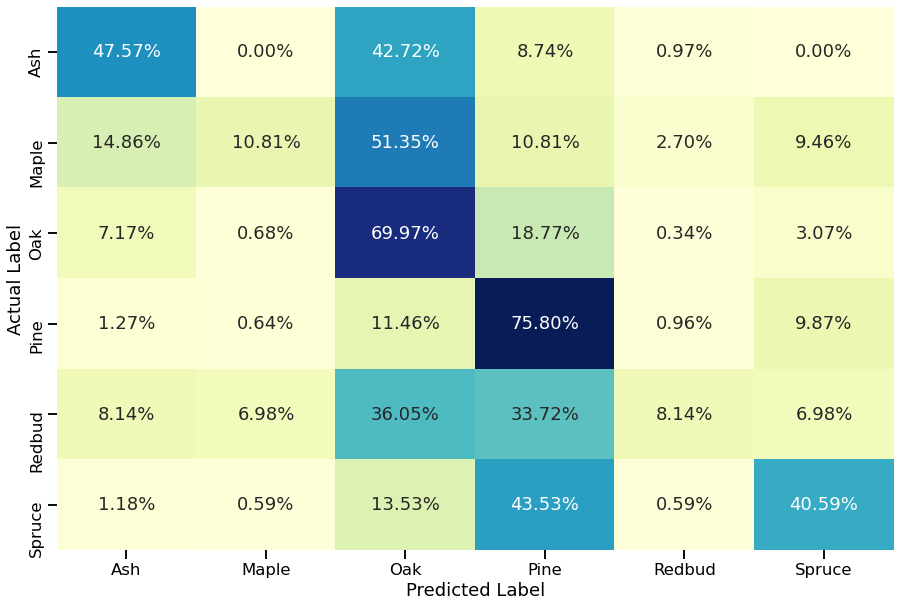

In [18]:
#prepare data for august
df_aug = df_aug.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_aug[df_aug.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_aug.TARGET)

# #model for aug
model_name = 'canopy_multi4_ind_aug'
aug = joblib.load(glob.glob('../pixels/models/*aug.joblib')[0])
preds = aug.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
aug_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(aug_results)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


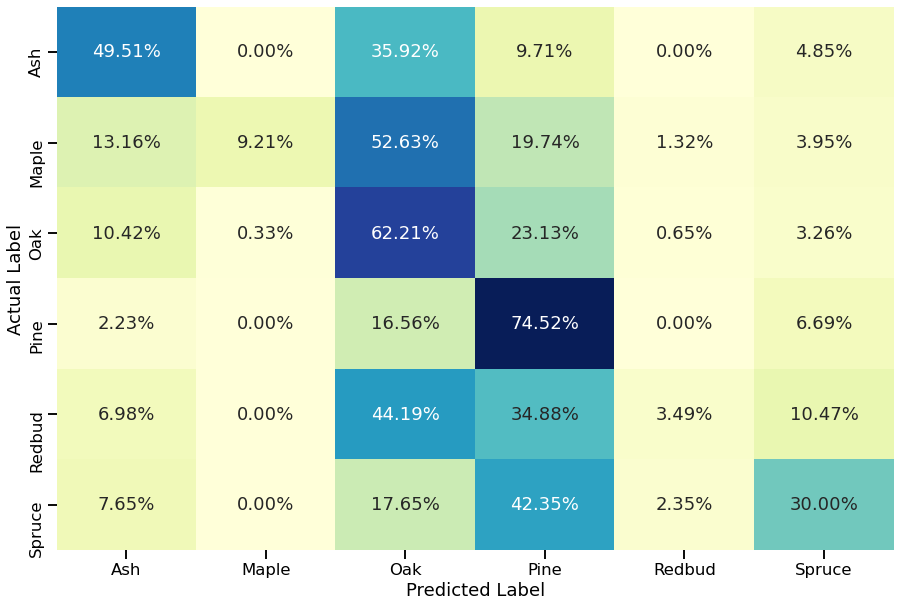

In [19]:
#prepare data for september e
df_sep = df_sep.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_sep[df_sep.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_sep.TARGET)

# #model for aug
model_name = 'canopy_multi4_ind_sep'
sep = joblib.load(glob.glob('../pixels/models/*sep.joblib')[0])
preds = sep.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
sep_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(sep_results)



[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


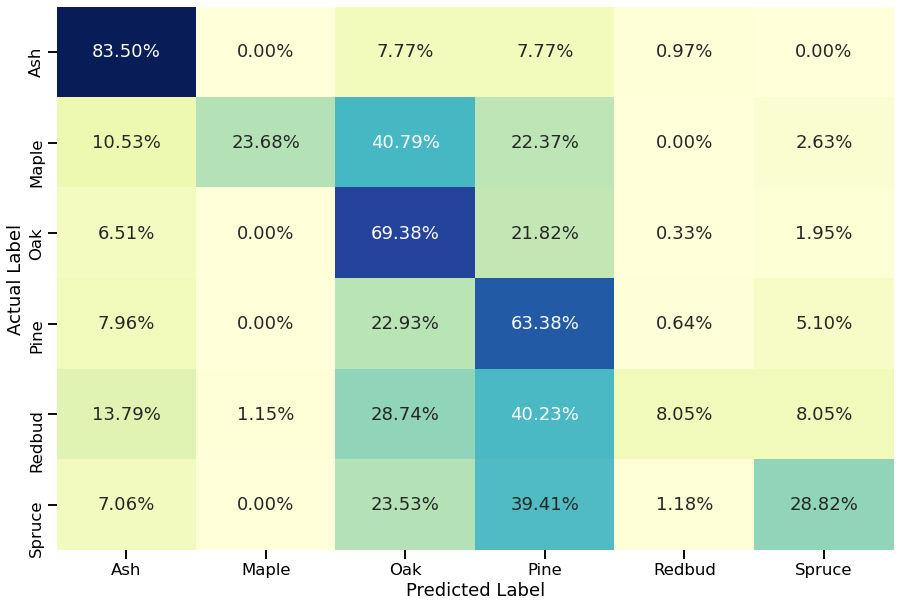

In [20]:
#prepare data for october
df_oct = df_oct.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_oct[df_oct.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_oct.TARGET)

# #model for aug
model_name = 'canopy_multi4_ind_oct'
octb = joblib.load(glob.glob('../pixels/models/*oct.joblib')[0])
preds = octb.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)
#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
oct_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(oct_results)

In [21]:
df_results = pd.concat(evals)
df_results

,Model,Test Accuracy(%)
0,canopy_multi4_ind_aug,55.384615
0,canopy_multi4_ind_sep,50.852273
0,canopy_multi4_ind_oct,54.115421


In [22]:
df_results.to_csv("canopy_multi4_ind_summary_results.csv")